In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np 
from scipy import signal 
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-01-15 12:11:28.683219: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 12:11:28.730214: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 12:11:28.730246: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 12:11:28.730279: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 12:11:28.739973: I tensorflow/core/platform/cpu_feature_g

In [2]:
x=np.load('../BraiNeoCare/Datasets/GAT/zenodo_data_consensus_GAT.npy', mmap_mode='r')
y=np.load('../BraiNeoCare/Datasets/GAT/zenodo_labels_consensus_GAT.npy', mmap_mode='r')


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [15]:
x1=np.load("../BraiNeoCare/Datasets/GAT/zenodo_data_non_GAT.npy", mmap_mode='r')
y1=np.load("../BraiNeoCare/Datasets/GAT/zenodo_labels_non_GAT.npy", mmap_mode='r')


In [3]:
mean=x_train.mean()
std=x_train.std()
x_train=(x_train-mean)/std
x_test=(x_test-mean)/std
# x1=(x1-mean)/std

x_train=np.expand_dims(x_train,axis=-1)
x_test=np.expand_dims(x_test,axis=-1)
# x1=np.expand_dims(x1,axis=-1)

In [16]:
x1=(x1-mean)/std
x1=np.expand_dims(x1,axis=-1)


In [15]:
y_train=y_train.astype(np.float32)
y_test=y_test.astype(np.float32)

In [4]:
channel_names=["Fp1-T3","T3-O1","Fp1-C3","C3-O1","Fp2-C4","C4-O2","Fp2-T4","T4-O2","T3-C3","C3-Cz","Cz-C4","C4-T4"]
indices =[[r,i] for r,c1 in enumerate(channel_names) for i,c2 in enumerate(channel_names) if (c1.split("-")[0]==c2.split("-")[1] or c1.split("-")[1]==c2.split("-")[1] 
          or c1.split("-")[0]==c2.split("-")[0] or c1.split("-")[1]==c2.split("-")[0])]
adj=np.zeros((12,12))
for i in indices:
    adj[i[0]][i[1]]=1
adj=tf.constant(adj,dtype=tf.float32)

2024-01-15 12:13:28.057641: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14947 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5
2024-01-15 12:13:28.058347: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14946 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:73:00.0, compute capability: 7.5


In [5]:
class GATLayer(layers.Layer):

    def __init__(self,output_dim):
        super(GATLayer, self).__init__()
        self.output_dim = output_dim
        self.LeakyReLU = layers.LeakyReLU(alpha=0.2)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='W',shape=(input_shape[-1], self.output_dim), initializer='random_normal',trainable=True)
        self.a = self.add_weight(name='a',shape=(2*self.output_dim, 1), initializer='random_normal',trainable=True)
    
    def call(self,input,adj):
        H= tf.matmul(input, self.W)
        h1=tf.tile(tf.expand_dims(H, axis=1), [1,12,1,1])
        h2=tf.tile(tf.expand_dims(H, axis=2), [1,1,12,1])
        result =tf.concat([h1 , h2], axis=-1)
        e=self.LeakyReLU(tf.squeeze(tf.matmul(result, self.a),axis=-1))
        zero_mat=-1e20*tf.zeros_like(e)
        msked_e=tf.where(adj==1,e,zero_mat)
        alpha=tf.nn.softmax(msked_e,axis=-1)
        HPrime=tf.matmul(alpha,H)
        return tf.nn.elu(HPrime)


Input= keras.Input(shape=(12,384,1))

x= layers.Conv2D(32,(1,3),activation='relu',padding='same')(Input)
y= layers.Conv2D(32,(1,5),activation='relu',padding='same')(Input)
x= layers.add([x,y])
x= layers.MaxPooling2D((1,2))(x)
x= layers.BatchNormalization()(x)
x= layers.SpatialDropout2D(0.1)(x)

x= layers.Conv2D(64,(1,3),activation='relu',padding='same')(x)
y= layers.Conv2D(64,(1,5),activation='relu',padding='same')(x)
x= layers.add([x,y])
x= layers.MaxPooling2D((1,2))(x)
x= layers.BatchNormalization()(x)
x= layers.SpatialDropout2D(0.1)(x)

x= layers.Conv2D(8,(1,3),activation='relu',padding='same')(x)
y= layers.Conv2D(8,(1,5),activation='relu',padding='same')(x)
x= layers.add([x,y])
x= layers.MaxPooling2D((1,2))(x)
x= layers.BatchNormalization()(x)
x= layers.SpatialDropout2D(0.1)(x)

x= layers.Conv2D(1,(1,3),activation='relu',padding='same')(x)
y= layers.Conv2D(1,(1,5),activation='relu',padding='same')(x)
x= layers.add([x,y])
x= layers.MaxPooling2D((1,2))(x)
x= layers.Reshape((12,24))(x)

x= GATLayer(37)(x,adj)
x= GATLayer(32)(x,adj)
x= GATLayer(16)(x,adj)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x= layers.Dense(32,activation='relu')(x)
x= layers.Dropout(0.1)(x)
x = layers.Dense(16,activation='relu')(x)
x = layers.Dense(1,activation='sigmoid')(x)

model = keras.Model(inputs=Input, outputs=x)

In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 12, 384, 1)]         0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 12, 384, 32)          128       ['input_2[0][0]']             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 12, 384, 32)          192       ['input_2[0][0]']             
                                                                                                  
 add_4 (Add)                 (None, 12, 384, 32)          0         ['conv2d_8[0][0]',            
                                                                     'conv2d_9[0][0]']      

In [6]:
optimizer=keras.optimizers.Adam(learning_rate=0.002,weight_decay=0.0025)
loss=keras.losses.BinaryFocalCrossentropy(from_logits=False,gamma=2,alpha=0.4,apply_class_balancing=True)
# loss=keras.losses.BinaryCrossentropy(from_logits=False)  
# F1=keras.metrics.F1Score(threshold=0.5, name='F1') 
precision = keras.metrics.Precision()
recall = keras.metrics.Recall()
AUROC = keras.metrics.AUC(curve='ROC', name = 'AUROC')
AUPRC = keras.metrics.AUC(curve='PR', name = 'AUPRC')
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy', AUROC, AUPRC, precision, recall])    

In [7]:
checkpoint_path = "GAT_model_2/cp_{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path) 
cp_callback=keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=False,verbose=0,save_best_only=True,monitor='val_accuracy')  
history=model.fit(x_train,y_train,epochs=200,batch_size=512,verbose=1,validation_data=(x_test,y_test),callbacks=[cp_callback])

Epoch 1/200


2024-01-15 12:15:02.995740: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/spatial_dropout2d/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-15 12:15:03.637973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-15 12:15:07.165144: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe9b0a43590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-15 12:15:07.165174: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2024-01-15 12:15:07.165180: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Quadro RTX 5000, Compute Capability 7.5
2024-01-15 12:15:07.171127: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproduc

203/203 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.7218 - AUROC: 0.7480 - AUPRC: 0.6302 - precision: 0.8511 - recall: 0.1931INFO:tensorflow:Assets written to: GAT_model_2/cp_0001.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0001.ckpt/assets


203/203 [==============================] - 54s 210ms/step - loss: 0.0666 - accuracy: 0.7218 - AUROC: 0.7480 - AUPRC: 0.6302 - precision: 0.8511 - recall: 0.1931 - val_loss: 0.0710 - val_accuracy: 0.7555 - val_AUROC: 0.6999 - val_AUPRC: 0.6343 - val_precision: 0.9123 - val_recall: 0.2756
Epoch 2/200
202/203 [============================>.] - ETA: 0s - loss: 0.0453 - accuracy: 0.8552 - AUROC: 0.8884 - AUPRC: 0.8513 - precision: 0.9021 - recall: 0.6307INFO:tensorflow:Assets written to: GAT_model_2/cp_0002.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0002.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0453 - accuracy: 0.8552 - AUROC: 0.8884 - AUPRC: 0.8513 - precision: 0.9021 - recall: 0.6307 - val_loss: 0.0777 - val_accuracy: 0.7696 - val_AUROC: 0.8562 - val_AUPRC: 0.8298 - val_precision: 0.9809 - val_recall: 0.2983
Epoch 3/200
202/203 [============================>.] - ETA: 0s - loss: 0.0406 - accuracy: 0.8783 - AUROC: 0.9086 - AUPRC: 0.8793 - precision: 0.9187 - recall: 0.6936INFO:tensorflow:Assets written to: GAT_model_2/cp_0003.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0003.ckpt/assets


203/203 [==============================] - 40s 195ms/step - loss: 0.0406 - accuracy: 0.8783 - AUROC: 0.9085 - AUPRC: 0.8793 - precision: 0.9187 - recall: 0.6935 - val_loss: 0.0441 - val_accuracy: 0.8484 - val_AUROC: 0.9079 - val_AUPRC: 0.8836 - val_precision: 0.9727 - val_recall: 0.5499
Epoch 4/200
202/203 [============================>.] - ETA: 0s - loss: 0.0375 - accuracy: 0.8878 - AUROC: 0.9235 - AUPRC: 0.8971 - precision: 0.9274 - recall: 0.7170INFO:tensorflow:Assets written to: GAT_model_2/cp_0004.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0004.ckpt/assets


203/203 [==============================] - 40s 199ms/step - loss: 0.0375 - accuracy: 0.8878 - AUROC: 0.9235 - AUPRC: 0.8970 - precision: 0.9274 - recall: 0.7170 - val_loss: 0.0408 - val_accuracy: 0.8598 - val_AUROC: 0.9338 - val_AUPRC: 0.9085 - val_precision: 0.9764 - val_recall: 0.5835
Epoch 5/200
203/203 [==============================] - 37s 182ms/step - loss: 0.0360 - accuracy: 0.8934 - AUROC: 0.9295 - AUPRC: 0.9053 - precision: 0.9296 - recall: 0.7333 - val_loss: 0.0578 - val_accuracy: 0.8057 - val_AUROC: 0.9151 - val_AUPRC: 0.8851 - val_precision: 0.9843 - val_recall: 0.4100
Epoch 6/200
202/203 [============================>.] - ETA: 0s - loss: 0.0360 - accuracy: 0.8934 - AUROC: 0.9297 - AUPRC: 0.9044 - precision: 0.9303 - recall: 0.7326INFO:tensorflow:Assets written to: GAT_model_2/cp_0006.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0006.ckpt/assets


203/203 [==============================] - 400s 2s/step - loss: 0.0360 - accuracy: 0.8934 - AUROC: 0.9297 - AUPRC: 0.9044 - precision: 0.9303 - recall: 0.7327 - val_loss: 0.0332 - val_accuracy: 0.8988 - val_AUROC: 0.9446 - val_AUPRC: 0.9232 - val_precision: 0.9588 - val_recall: 0.7204
Epoch 7/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0343 - accuracy: 0.8984 - AUROC: 0.9363 - AUPRC: 0.9137 - precision: 0.9325 - recall: 0.7469 - val_loss: 0.0400 - val_accuracy: 0.8790 - val_AUROC: 0.9374 - val_AUPRC: 0.9165 - val_precision: 0.9762 - val_recall: 0.6441
Epoch 8/200
203/203 [==============================] - 137s 676ms/step - loss: 0.0339 - accuracy: 0.9005 - AUROC: 0.9382 - AUPRC: 0.9159 - precision: 0.9343 - recall: 0.7522 - val_loss: 0.0388 - val_accuracy: 0.8726 - val_AUROC: 0.9459 - val_AUPRC: 0.9256 - val_precision: 0.9780 - val_recall: 0.6228
Epoch 9/200
202/203 [============================>.] - ETA: 0s - loss: 0.0333 - accuracy: 0.9028 - AUROC: 0.9398 

INFO:tensorflow:Assets written to: GAT_model_2/cp_0009.ckpt/assets


203/203 [==============================] - 40s 196ms/step - loss: 0.0333 - accuracy: 0.9028 - AUROC: 0.9398 - AUPRC: 0.9191 - precision: 0.9347 - recall: 0.7594 - val_loss: 0.0322 - val_accuracy: 0.9042 - val_AUROC: 0.9428 - val_AUPRC: 0.9240 - val_precision: 0.9562 - val_recall: 0.7396
Epoch 10/200
203/203 [==============================] - 37s 182ms/step - loss: 0.0328 - accuracy: 0.9045 - AUROC: 0.9417 - AUPRC: 0.9211 - precision: 0.9319 - recall: 0.7676 - val_loss: 0.0348 - val_accuracy: 0.8902 - val_AUROC: 0.9448 - val_AUPRC: 0.9253 - val_precision: 0.9747 - val_recall: 0.6805
Epoch 11/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0319 - accuracy: 0.9072 - AUROC: 0.9447 - AUPRC: 0.9257 - precision: 0.9355 - recall: 0.7728 - val_loss: 0.0319 - val_accuracy: 0.9038 - val_AUROC: 0.9491 - val_AUPRC: 0.9319 - val_precision: 0.9696 - val_recall: 0.7275
Epoch 12/200
202/203 [============================>.] - ETA: 0s - loss: 0.0313 - accuracy: 0.9094 - AUROC: 0.9

INFO:tensorflow:Assets written to: GAT_model_2/cp_0012.ckpt/assets


203/203 [==============================] - 40s 197ms/step - loss: 0.0313 - accuracy: 0.9094 - AUROC: 0.9462 - AUPRC: 0.9282 - precision: 0.9394 - recall: 0.7763 - val_loss: 0.0299 - val_accuracy: 0.9117 - val_AUROC: 0.9549 - val_AUPRC: 0.9376 - val_precision: 0.9511 - val_recall: 0.7685
Epoch 13/200
202/203 [============================>.] - ETA: 0s - loss: 0.0304 - accuracy: 0.9117 - AUROC: 0.9499 - AUPRC: 0.9323 - precision: 0.9398 - recall: 0.7832INFO:tensorflow:Assets written to: GAT_model_2/cp_0013.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0013.ckpt/assets


203/203 [==============================] - 39s 195ms/step - loss: 0.0304 - accuracy: 0.9117 - AUROC: 0.9499 - AUPRC: 0.9323 - precision: 0.9398 - recall: 0.7832 - val_loss: 0.0287 - val_accuracy: 0.9171 - val_AUROC: 0.9593 - val_AUPRC: 0.9430 - val_precision: 0.9532 - val_recall: 0.7838
Epoch 14/200
203/203 [==============================] - 37s 182ms/step - loss: 0.0299 - accuracy: 0.9130 - AUROC: 0.9516 - AUPRC: 0.9350 - precision: 0.9409 - recall: 0.7865 - val_loss: 0.0317 - val_accuracy: 0.9036 - val_AUROC: 0.9539 - val_AUPRC: 0.9370 - val_precision: 0.9717 - val_recall: 0.7250
Epoch 15/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0302 - accuracy: 0.9126 - AUROC: 0.9508 - AUPRC: 0.9336 - precision: 0.9382 - recall: 0.7876 - val_loss: 0.0306 - val_accuracy: 0.9097 - val_AUROC: 0.9527 - val_AUPRC: 0.9369 - val_precision: 0.9705 - val_recall: 0.7455
Epoch 16/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0293 - accuracy: 0.9149 - AUR

INFO:tensorflow:Assets written to: GAT_model_2/cp_0017.ckpt/assets


203/203 [==============================] - 40s 198ms/step - loss: 0.0294 - accuracy: 0.9138 - AUROC: 0.9537 - AUPRC: 0.9370 - precision: 0.9444 - recall: 0.7858 - val_loss: 0.0287 - val_accuracy: 0.9176 - val_AUROC: 0.9587 - val_AUPRC: 0.9426 - val_precision: 0.9599 - val_recall: 0.7796
Epoch 18/200
202/203 [============================>.] - ETA: 0s - loss: 0.0282 - accuracy: 0.9177 - AUROC: 0.9573 - AUPRC: 0.9417 - precision: 0.9466 - recall: 0.7962INFO:tensorflow:Assets written to: GAT_model_2/cp_0018.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0018.ckpt/assets


203/203 [==============================] - 40s 198ms/step - loss: 0.0282 - accuracy: 0.9177 - AUROC: 0.9574 - AUPRC: 0.9417 - precision: 0.9466 - recall: 0.7963 - val_loss: 0.0266 - val_accuracy: 0.9244 - val_AUROC: 0.9629 - val_AUPRC: 0.9492 - val_precision: 0.9468 - val_recall: 0.8135
Epoch 19/200
203/203 [==============================] - 37s 182ms/step - loss: 0.0276 - accuracy: 0.9199 - AUROC: 0.9594 - AUPRC: 0.9441 - precision: 0.9459 - recall: 0.8039 - val_loss: 0.0354 - val_accuracy: 0.8852 - val_AUROC: 0.9576 - val_AUPRC: 0.9418 - val_precision: 0.9826 - val_recall: 0.6590
Epoch 20/200
203/203 [==============================] - 37s 182ms/step - loss: 0.0282 - accuracy: 0.9178 - AUROC: 0.9576 - AUPRC: 0.9415 - precision: 0.9444 - recall: 0.7984 - val_loss: 0.0285 - val_accuracy: 0.9202 - val_AUROC: 0.9567 - val_AUPRC: 0.9409 - val_precision: 0.9223 - val_recall: 0.8244
Epoch 21/200
202/203 [============================>.] - ETA: 0s - loss: 0.0286 - accuracy: 0.9164 - AUROC: 0.9

INFO:tensorflow:Assets written to: GAT_model_2/cp_0021.ckpt/assets


203/203 [==============================] - 40s 196ms/step - loss: 0.0286 - accuracy: 0.9164 - AUROC: 0.9564 - AUPRC: 0.9399 - precision: 0.9453 - recall: 0.7933 - val_loss: 0.0331 - val_accuracy: 0.9258 - val_AUROC: 0.9665 - val_AUPRC: 0.9522 - val_precision: 0.9026 - val_recall: 0.8656
Epoch 22/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0273 - accuracy: 0.9204 - AUROC: 0.9605 - AUPRC: 0.9457 - precision: 0.9444 - recall: 0.8069 - val_loss: 0.0261 - val_accuracy: 0.9208 - val_AUROC: 0.9661 - val_AUPRC: 0.9511 - val_precision: 0.9646 - val_recall: 0.7856
Epoch 23/200
202/203 [============================>.] - ETA: 0s - loss: 0.0264 - accuracy: 0.9225 - AUROC: 0.9634 - AUPRC: 0.9488 - precision: 0.9481 - recall: 0.8102INFO:tensorflow:Assets written to: GAT_model_2/cp_0023.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0023.ckpt/assets


203/203 [==============================] - 40s 198ms/step - loss: 0.0264 - accuracy: 0.9225 - AUROC: 0.9634 - AUPRC: 0.9488 - precision: 0.9481 - recall: 0.8102 - val_loss: 0.0252 - val_accuracy: 0.9271 - val_AUROC: 0.9670 - val_AUPRC: 0.9536 - val_precision: 0.9624 - val_recall: 0.8079
Epoch 24/200
202/203 [============================>.] - ETA: 0s - loss: 0.0261 - accuracy: 0.9250 - AUROC: 0.9645 - AUPRC: 0.9499 - precision: 0.9420 - recall: 0.8242INFO:tensorflow:Assets written to: GAT_model_2/cp_0024.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0024.ckpt/assets


203/203 [==============================] - 40s 197ms/step - loss: 0.0261 - accuracy: 0.9250 - AUROC: 0.9645 - AUPRC: 0.9499 - precision: 0.9420 - recall: 0.8242 - val_loss: 0.0245 - val_accuracy: 0.9318 - val_AUROC: 0.9715 - val_AUPRC: 0.9584 - val_precision: 0.9468 - val_recall: 0.8376
Epoch 25/200
203/203 [==============================] - 37s 182ms/step - loss: 0.0263 - accuracy: 0.9241 - AUROC: 0.9638 - AUPRC: 0.9494 - precision: 0.9427 - recall: 0.8204 - val_loss: 0.0258 - val_accuracy: 0.9267 - val_AUROC: 0.9693 - val_AUPRC: 0.9542 - val_precision: 0.9543 - val_recall: 0.8138
Epoch 26/200
202/203 [============================>.] - ETA: 0s - loss: 0.0255 - accuracy: 0.9246 - AUROC: 0.9663 - AUPRC: 0.9521 - precision: 0.9470 - recall: 0.8179INFO:tensorflow:Assets written to: GAT_model_2/cp_0026.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0026.ckpt/assets


203/203 [==============================] - 40s 196ms/step - loss: 0.0255 - accuracy: 0.9246 - AUROC: 0.9663 - AUPRC: 0.9520 - precision: 0.9470 - recall: 0.8179 - val_loss: 0.0263 - val_accuracy: 0.9326 - val_AUROC: 0.9712 - val_AUPRC: 0.9578 - val_precision: 0.9437 - val_recall: 0.8433
Epoch 27/200
202/203 [============================>.] - ETA: 0s - loss: 0.0257 - accuracy: 0.9247 - AUROC: 0.9657 - AUPRC: 0.9518 - precision: 0.9467 - recall: 0.8185INFO:tensorflow:Assets written to: GAT_model_2/cp_0027.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0027.ckpt/assets


203/203 [==============================] - 40s 197ms/step - loss: 0.0257 - accuracy: 0.9247 - AUROC: 0.9657 - AUPRC: 0.9518 - precision: 0.9467 - recall: 0.8185 - val_loss: 0.0246 - val_accuracy: 0.9363 - val_AUROC: 0.9736 - val_AUPRC: 0.9611 - val_precision: 0.9372 - val_recall: 0.8623
Epoch 28/200
203/203 [==============================] - 37s 183ms/step - loss: 0.0252 - accuracy: 0.9252 - AUROC: 0.9671 - AUPRC: 0.9534 - precision: 0.9480 - recall: 0.8187 - val_loss: 0.0252 - val_accuracy: 0.9336 - val_AUROC: 0.9689 - val_AUPRC: 0.9565 - val_precision: 0.9384 - val_recall: 0.8521
Epoch 29/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0252 - accuracy: 0.9266 - AUROC: 0.9669 - AUPRC: 0.9535 - precision: 0.9459 - recall: 0.8253 - val_loss: 0.0236 - val_accuracy: 0.9358 - val_AUROC: 0.9721 - val_AUPRC: 0.9599 - val_precision: 0.9341 - val_recall: 0.8637
Epoch 30/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0242 - accuracy: 0.9293 - AUR

INFO:tensorflow:Assets written to: GAT_model_2/cp_0032.ckpt/assets


203/203 [==============================] - 39s 195ms/step - loss: 0.0240 - accuracy: 0.9300 - AUROC: 0.9702 - AUPRC: 0.9576 - precision: 0.9476 - recall: 0.8344 - val_loss: 0.0218 - val_accuracy: 0.9401 - val_AUROC: 0.9763 - val_AUPRC: 0.9654 - val_precision: 0.9516 - val_recall: 0.8599
Epoch 33/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0236 - accuracy: 0.9310 - AUROC: 0.9715 - AUPRC: 0.9590 - precision: 0.9503 - recall: 0.8352 - val_loss: 0.0248 - val_accuracy: 0.9398 - val_AUROC: 0.9753 - val_AUPRC: 0.9639 - val_precision: 0.9451 - val_recall: 0.8652
Epoch 34/200
202/203 [============================>.] - ETA: 0s - loss: 0.0232 - accuracy: 0.9328 - AUROC: 0.9727 - AUPRC: 0.9603 - precision: 0.9495 - recall: 0.8416INFO:tensorflow:Assets written to: GAT_model_2/cp_0034.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0034.ckpt/assets


203/203 [==============================] - 40s 197ms/step - loss: 0.0232 - accuracy: 0.9328 - AUROC: 0.9727 - AUPRC: 0.9603 - precision: 0.9495 - recall: 0.8416 - val_loss: 0.0207 - val_accuracy: 0.9415 - val_AUROC: 0.9790 - val_AUPRC: 0.9681 - val_precision: 0.9628 - val_recall: 0.8532
Epoch 35/200
202/203 [============================>.] - ETA: 0s - loss: 0.0231 - accuracy: 0.9325 - AUROC: 0.9728 - AUPRC: 0.9606 - precision: 0.9503 - recall: 0.8400INFO:tensorflow:Assets written to: GAT_model_2/cp_0035.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0035.ckpt/assets


203/203 [==============================] - 40s 196ms/step - loss: 0.0231 - accuracy: 0.9325 - AUROC: 0.9728 - AUPRC: 0.9606 - precision: 0.9503 - recall: 0.8399 - val_loss: 0.0246 - val_accuracy: 0.9426 - val_AUROC: 0.9784 - val_AUPRC: 0.9674 - val_precision: 0.9267 - val_recall: 0.8946
Epoch 36/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0243 - accuracy: 0.9288 - AUROC: 0.9701 - AUPRC: 0.9569 - precision: 0.9489 - recall: 0.8296 - val_loss: 0.0215 - val_accuracy: 0.9418 - val_AUROC: 0.9787 - val_AUPRC: 0.9677 - val_precision: 0.9538 - val_recall: 0.8630
Epoch 37/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0226 - accuracy: 0.9341 - AUROC: 0.9742 - AUPRC: 0.9623 - precision: 0.9498 - recall: 0.8454 - val_loss: 0.0236 - val_accuracy: 0.9274 - val_AUROC: 0.9758 - val_AUPRC: 0.9642 - val_precision: 0.9800 - val_recall: 0.7933
Epoch 38/200
203/203 [==============================] - 37s 183ms/step - loss: 0.0224 - accuracy: 0.9353 - AUR

INFO:tensorflow:Assets written to: GAT_model_2/cp_0040.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0216 - accuracy: 0.9371 - AUROC: 0.9765 - AUPRC: 0.9652 - precision: 0.9516 - recall: 0.8532 - val_loss: 0.0200 - val_accuracy: 0.9442 - val_AUROC: 0.9797 - val_AUPRC: 0.9697 - val_precision: 0.9586 - val_recall: 0.8659
Epoch 41/200
202/203 [============================>.] - ETA: 0s - loss: 0.0221 - accuracy: 0.9357 - AUROC: 0.9758 - AUPRC: 0.9637 - precision: 0.9501 - recall: 0.8504INFO:tensorflow:Assets written to: GAT_model_2/cp_0041.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0041.ckpt/assets


203/203 [==============================] - 40s 196ms/step - loss: 0.0221 - accuracy: 0.9357 - AUROC: 0.9758 - AUPRC: 0.9637 - precision: 0.9501 - recall: 0.8504 - val_loss: 0.0207 - val_accuracy: 0.9454 - val_AUROC: 0.9811 - val_AUPRC: 0.9711 - val_precision: 0.9639 - val_recall: 0.8646
Epoch 42/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0218 - accuracy: 0.9360 - AUROC: 0.9764 - AUPRC: 0.9648 - precision: 0.9505 - recall: 0.8508 - val_loss: 0.0212 - val_accuracy: 0.9434 - val_AUROC: 0.9788 - val_AUPRC: 0.9682 - val_precision: 0.9458 - val_recall: 0.8764
Epoch 43/200
203/203 [==============================] - 37s 182ms/step - loss: 0.0213 - accuracy: 0.9379 - AUROC: 0.9774 - AUPRC: 0.9661 - precision: 0.9519 - recall: 0.8555 - val_loss: 0.0235 - val_accuracy: 0.9370 - val_AUROC: 0.9738 - val_AUPRC: 0.9613 - val_precision: 0.9354 - val_recall: 0.8665
Epoch 44/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0213 - accuracy: 0.9379 - AUR

INFO:tensorflow:Assets written to: GAT_model_2/cp_0045.ckpt/assets


203/203 [==============================] - 40s 199ms/step - loss: 0.0208 - accuracy: 0.9392 - AUROC: 0.9787 - AUPRC: 0.9680 - precision: 0.9530 - recall: 0.8586 - val_loss: 0.0202 - val_accuracy: 0.9475 - val_AUROC: 0.9811 - val_AUPRC: 0.9718 - val_precision: 0.9397 - val_recall: 0.8963
Epoch 46/200
203/203 [==============================] - 127s 628ms/step - loss: 0.0210 - accuracy: 0.9379 - AUROC: 0.9781 - AUPRC: 0.9671 - precision: 0.9542 - recall: 0.8531 - val_loss: 0.0262 - val_accuracy: 0.9124 - val_AUROC: 0.9767 - val_AUPRC: 0.9624 - val_precision: 0.9811 - val_recall: 0.7454
Epoch 47/200
202/203 [============================>.] - ETA: 0s - loss: 0.0215 - accuracy: 0.9372 - AUROC: 0.9774 - AUPRC: 0.9656 - precision: 0.9509 - recall: 0.8542INFO:tensorflow:Assets written to: GAT_model_2/cp_0047.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0047.ckpt/assets


203/203 [==============================] - 40s 197ms/step - loss: 0.0215 - accuracy: 0.9372 - AUROC: 0.9774 - AUPRC: 0.9656 - precision: 0.9509 - recall: 0.8542 - val_loss: 0.0208 - val_accuracy: 0.9479 - val_AUROC: 0.9816 - val_AUPRC: 0.9717 - val_precision: 0.9435 - val_recall: 0.8936
Epoch 48/200
203/203 [==============================] - 128s 631ms/step - loss: 0.0204 - accuracy: 0.9398 - AUROC: 0.9796 - AUPRC: 0.9689 - precision: 0.9524 - recall: 0.8609 - val_loss: 0.0194 - val_accuracy: 0.9477 - val_AUROC: 0.9815 - val_AUPRC: 0.9728 - val_precision: 0.9615 - val_recall: 0.8744
Epoch 49/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0202 - accuracy: 0.9406 - AUROC: 0.9799 - AUPRC: 0.9696 - precision: 0.9546 - recall: 0.8616 - val_loss: 0.0190 - val_accuracy: 0.9430 - val_AUROC: 0.9825 - val_AUPRC: 0.9732 - val_precision: 0.9653 - val_recall: 0.8557
Epoch 50/200
203/203 [==============================] - 429s 2s/step - loss: 0.0198 - accuracy: 0.9420 - AURO

INFO:tensorflow:Assets written to: GAT_model_2/cp_0055.ckpt/assets


203/203 [==============================] - 40s 197ms/step - loss: 0.0189 - accuracy: 0.9445 - AUROC: 0.9827 - AUPRC: 0.9730 - precision: 0.9538 - recall: 0.8745 - val_loss: 0.0179 - val_accuracy: 0.9528 - val_AUROC: 0.9854 - val_AUPRC: 0.9774 - val_precision: 0.9491 - val_recall: 0.9035
Epoch 56/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0188 - accuracy: 0.9449 - AUROC: 0.9829 - AUPRC: 0.9734 - precision: 0.9541 - recall: 0.8756 - val_loss: 0.0181 - val_accuracy: 0.9477 - val_AUROC: 0.9854 - val_AUPRC: 0.9767 - val_precision: 0.9745 - val_recall: 0.8620
Epoch 57/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0192 - accuracy: 0.9440 - AUROC: 0.9821 - AUPRC: 0.9723 - precision: 0.9533 - recall: 0.8735 - val_loss: 0.0183 - val_accuracy: 0.9480 - val_AUROC: 0.9833 - val_AUPRC: 0.9747 - val_precision: 0.9659 - val_recall: 0.8712
Epoch 58/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0193 - accuracy: 0.9430 - AUR

INFO:tensorflow:Assets written to: GAT_model_2/cp_0059.ckpt/assets


203/203 [==============================] - 40s 196ms/step - loss: 0.0186 - accuracy: 0.9456 - AUROC: 0.9834 - AUPRC: 0.9741 - precision: 0.9571 - recall: 0.8748 - val_loss: 0.0167 - val_accuracy: 0.9529 - val_AUROC: 0.9872 - val_AUPRC: 0.9793 - val_precision: 0.9665 - val_recall: 0.8863
Epoch 60/200
202/203 [============================>.] - ETA: 0s - loss: 0.0186 - accuracy: 0.9463 - AUROC: 0.9834 - AUPRC: 0.9741 - precision: 0.9522 - recall: 0.8819INFO:tensorflow:Assets written to: GAT_model_2/cp_0060.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0060.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0186 - accuracy: 0.9463 - AUROC: 0.9834 - AUPRC: 0.9741 - precision: 0.9522 - recall: 0.8819 - val_loss: 0.0191 - val_accuracy: 0.9532 - val_AUROC: 0.9870 - val_AUPRC: 0.9794 - val_precision: 0.9251 - val_recall: 0.9316
Epoch 61/200
202/203 [============================>.] - ETA: 0s - loss: 0.0183 - accuracy: 0.9471 - AUROC: 0.9839 - AUPRC: 0.9748 - precision: 0.9556 - recall: 0.8811INFO:tensorflow:Assets written to: GAT_model_2/cp_0061.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0061.ckpt/assets


203/203 [==============================] - 40s 197ms/step - loss: 0.0183 - accuracy: 0.9471 - AUROC: 0.9838 - AUPRC: 0.9748 - precision: 0.9556 - recall: 0.8811 - val_loss: 0.0191 - val_accuracy: 0.9548 - val_AUROC: 0.9881 - val_AUPRC: 0.9798 - val_precision: 0.9562 - val_recall: 0.9026
Epoch 62/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0255 - accuracy: 0.9251 - AUROC: 0.9672 - AUPRC: 0.9521 - precision: 0.9402 - recall: 0.8262 - val_loss: 0.0205 - val_accuracy: 0.9389 - val_AUROC: 0.9800 - val_AUPRC: 0.9698 - val_precision: 0.9740 - val_recall: 0.8348
Epoch 63/200
203/203 [==============================] - 37s 182ms/step - loss: 0.0207 - accuracy: 0.9383 - AUROC: 0.9790 - AUPRC: 0.9679 - precision: 0.9543 - recall: 0.8544 - val_loss: 0.0195 - val_accuracy: 0.9377 - val_AUROC: 0.9856 - val_AUPRC: 0.9771 - val_precision: 0.9820 - val_recall: 0.8239
Epoch 64/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0187 - accuracy: 0.9446 - AUR

INFO:tensorflow:Assets written to: GAT_model_2/cp_0069.ckpt/assets


203/203 [==============================] - 39s 195ms/step - loss: 0.0175 - accuracy: 0.9489 - AUROC: 0.9852 - AUPRC: 0.9767 - precision: 0.9583 - recall: 0.8842 - val_loss: 0.0153 - val_accuracy: 0.9571 - val_AUROC: 0.9898 - val_AUPRC: 0.9828 - val_precision: 0.9653 - val_recall: 0.9007
Epoch 70/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0179 - accuracy: 0.9469 - AUROC: 0.9847 - AUPRC: 0.9758 - precision: 0.9579 - recall: 0.8781 - val_loss: 0.0236 - val_accuracy: 0.9469 - val_AUROC: 0.9883 - val_AUPRC: 0.9813 - val_precision: 0.8922 - val_recall: 0.9519
Epoch 71/200
203/203 [==============================] - 140s 692ms/step - loss: 0.0175 - accuracy: 0.9490 - AUROC: 0.9855 - AUPRC: 0.9768 - precision: 0.9586 - recall: 0.8840 - val_loss: 0.0173 - val_accuracy: 0.9534 - val_AUROC: 0.9872 - val_AUPRC: 0.9791 - val_precision: 0.9629 - val_recall: 0.8912
Epoch 72/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0173 - accuracy: 0.9495 - AU

INFO:tensorflow:Assets written to: GAT_model_2/cp_0073.ckpt/assets


203/203 [==============================] - 140s 694ms/step - loss: 0.0170 - accuracy: 0.9503 - AUROC: 0.9861 - AUPRC: 0.9779 - precision: 0.9584 - recall: 0.8885 - val_loss: 0.0153 - val_accuracy: 0.9575 - val_AUROC: 0.9894 - val_AUPRC: 0.9829 - val_precision: 0.9709 - val_recall: 0.8965
Epoch 74/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0173 - accuracy: 0.9487 - AUROC: 0.9856 - AUPRC: 0.9773 - precision: 0.9580 - recall: 0.8838 - val_loss: 0.0228 - val_accuracy: 0.9219 - val_AUROC: 0.9858 - val_AUPRC: 0.9768 - val_precision: 0.9890 - val_recall: 0.7688
Epoch 75/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0190 - accuracy: 0.9432 - AUROC: 0.9830 - AUPRC: 0.9729 - precision: 0.9578 - recall: 0.8665 - val_loss: 0.0196 - val_accuracy: 0.9512 - val_AUROC: 0.9870 - val_AUPRC: 0.9797 - val_precision: 0.9133 - val_recall: 0.9392
Epoch 76/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0168 - accuracy: 0.9506 - AU

INFO:tensorflow:Assets written to: GAT_model_2/cp_0080.ckpt/assets


203/203 [==============================] - 40s 196ms/step - loss: 0.0164 - accuracy: 0.9522 - AUROC: 0.9872 - AUPRC: 0.9796 - precision: 0.9609 - recall: 0.8918 - val_loss: 0.0151 - val_accuracy: 0.9592 - val_AUROC: 0.9901 - val_AUPRC: 0.9834 - val_precision: 0.9611 - val_recall: 0.9115
Epoch 81/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0166 - accuracy: 0.9511 - AUROC: 0.9870 - AUPRC: 0.9792 - precision: 0.9592 - recall: 0.8902 - val_loss: 0.0158 - val_accuracy: 0.9525 - val_AUROC: 0.9891 - val_AUPRC: 0.9819 - val_precision: 0.9790 - val_recall: 0.8730
Epoch 82/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0163 - accuracy: 0.9531 - AUROC: 0.9874 - AUPRC: 0.9797 - precision: 0.9592 - recall: 0.8964 - val_loss: 0.0178 - val_accuracy: 0.9465 - val_AUROC: 0.9874 - val_AUPRC: 0.9805 - val_precision: 0.9846 - val_recall: 0.8490
Epoch 83/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0173 - accuracy: 0.9489 - AUR

INFO:tensorflow:Assets written to: GAT_model_2/cp_0084.ckpt/assets


203/203 [==============================] - 39s 193ms/step - loss: 0.0168 - accuracy: 0.9501 - AUROC: 0.9866 - AUPRC: 0.9786 - precision: 0.9589 - recall: 0.8871 - val_loss: 0.0150 - val_accuracy: 0.9595 - val_AUROC: 0.9904 - val_AUPRC: 0.9842 - val_precision: 0.9733 - val_recall: 0.9003
Epoch 85/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0162 - accuracy: 0.9528 - AUROC: 0.9877 - AUPRC: 0.9799 - precision: 0.9587 - recall: 0.8959 - val_loss: 0.0192 - val_accuracy: 0.9515 - val_AUROC: 0.9858 - val_AUPRC: 0.9784 - val_precision: 0.9262 - val_recall: 0.9248
Epoch 86/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0166 - accuracy: 0.9508 - AUROC: 0.9869 - AUPRC: 0.9791 - precision: 0.9612 - recall: 0.8870 - val_loss: 0.0244 - val_accuracy: 0.9338 - val_AUROC: 0.9826 - val_AUPRC: 0.9744 - val_precision: 0.9864 - val_recall: 0.8079
Epoch 87/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0175 - accuracy: 0.9484 - AUR

INFO:tensorflow:Assets written to: GAT_model_2/cp_0089.ckpt/assets


203/203 [==============================] - 40s 195ms/step - loss: 0.0180 - accuracy: 0.9481 - AUROC: 0.9845 - AUPRC: 0.9756 - precision: 0.9543 - recall: 0.8856 - val_loss: 0.0147 - val_accuracy: 0.9621 - val_AUROC: 0.9917 - val_AUPRC: 0.9859 - val_precision: 0.9628 - val_recall: 0.9191
Epoch 90/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0159 - accuracy: 0.9533 - AUROC: 0.9880 - AUPRC: 0.9808 - precision: 0.9593 - recall: 0.8970 - val_loss: 0.0164 - val_accuracy: 0.9577 - val_AUROC: 0.9914 - val_AUPRC: 0.9858 - val_precision: 0.9170 - val_recall: 0.9565
Epoch 91/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0161 - accuracy: 0.9525 - AUROC: 0.9878 - AUPRC: 0.9803 - precision: 0.9593 - recall: 0.8942 - val_loss: 0.0163 - val_accuracy: 0.9601 - val_AUROC: 0.9904 - val_AUPRC: 0.9840 - val_precision: 0.9509 - val_recall: 0.9253
Epoch 92/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0158 - accuracy: 0.9541 - AUR

INFO:tensorflow:Assets written to: GAT_model_2/cp_0096.ckpt/assets


203/203 [==============================] - 40s 195ms/step - loss: 0.0154 - accuracy: 0.9542 - AUROC: 0.9889 - AUPRC: 0.9820 - precision: 0.9639 - recall: 0.8951 - val_loss: 0.0145 - val_accuracy: 0.9623 - val_AUROC: 0.9913 - val_AUPRC: 0.9860 - val_precision: 0.9748 - val_recall: 0.9079
Epoch 97/200
202/203 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9555 - AUROC: 0.9894 - AUPRC: 0.9827 - precision: 0.9655 - recall: 0.8975INFO:tensorflow:Assets written to: GAT_model_2/cp_0097.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0097.ckpt/assets


203/203 [==============================] - 39s 193ms/step - loss: 0.0150 - accuracy: 0.9555 - AUROC: 0.9894 - AUPRC: 0.9827 - precision: 0.9655 - recall: 0.8975 - val_loss: 0.0133 - val_accuracy: 0.9640 - val_AUROC: 0.9925 - val_AUPRC: 0.9872 - val_precision: 0.9660 - val_recall: 0.9219
Epoch 98/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0149 - accuracy: 0.9557 - AUROC: 0.9897 - AUPRC: 0.9829 - precision: 0.9628 - recall: 0.9008 - val_loss: 0.0152 - val_accuracy: 0.9631 - val_AUROC: 0.9919 - val_AUPRC: 0.9863 - val_precision: 0.9421 - val_recall: 0.9447
Epoch 99/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0151 - accuracy: 0.9550 - AUROC: 0.9893 - AUPRC: 0.9822 - precision: 0.9636 - recall: 0.8979 - val_loss: 0.0133 - val_accuracy: 0.9575 - val_AUROC: 0.9926 - val_AUPRC: 0.9874 - val_precision: 0.9821 - val_recall: 0.8857
Epoch 100/200
202/203 [============================>.] - ETA: 0s - loss: 0.0156 - accuracy: 0.9540 - AUROC: 0.

INFO:tensorflow:Assets written to: GAT_model_2/cp_0100.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0156 - accuracy: 0.9540 - AUROC: 0.9885 - AUPRC: 0.9813 - precision: 0.9628 - recall: 0.8957 - val_loss: 0.0168 - val_accuracy: 0.9650 - val_AUROC: 0.9922 - val_AUPRC: 0.9867 - val_precision: 0.9485 - val_recall: 0.9440
Epoch 101/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0153 - accuracy: 0.9546 - AUROC: 0.9890 - AUPRC: 0.9820 - precision: 0.9619 - recall: 0.8982 - val_loss: 0.0136 - val_accuracy: 0.9608 - val_AUROC: 0.9914 - val_AUPRC: 0.9852 - val_precision: 0.9698 - val_recall: 0.9080
Epoch 102/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0150 - accuracy: 0.9575 - AUROC: 0.9895 - AUPRC: 0.9828 - precision: 0.9594 - recall: 0.9099 - val_loss: 0.0140 - val_accuracy: 0.9630 - val_AUROC: 0.9917 - val_AUPRC: 0.9848 - val_precision: 0.9699 - val_recall: 0.9146
Epoch 103/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0147 - accuracy: 0.9579 - 

INFO:tensorflow:Assets written to: GAT_model_2/cp_0108.ckpt/assets


203/203 [==============================] - 40s 195ms/step - loss: 0.0145 - accuracy: 0.9575 - AUROC: 0.9901 - AUPRC: 0.9838 - precision: 0.9620 - recall: 0.9073 - val_loss: 0.0150 - val_accuracy: 0.9652 - val_AUROC: 0.9923 - val_AUPRC: 0.9864 - val_precision: 0.9526 - val_recall: 0.9398
Epoch 109/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0144 - accuracy: 0.9575 - AUROC: 0.9904 - AUPRC: 0.9840 - precision: 0.9649 - recall: 0.9045 - val_loss: 0.0137 - val_accuracy: 0.9586 - val_AUROC: 0.9914 - val_AUPRC: 0.9858 - val_precision: 0.9784 - val_recall: 0.8927
Epoch 110/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0147 - accuracy: 0.9567 - AUROC: 0.9900 - AUPRC: 0.9835 - precision: 0.9643 - recall: 0.9025 - val_loss: 0.0143 - val_accuracy: 0.9642 - val_AUROC: 0.9909 - val_AUPRC: 0.9859 - val_precision: 0.9590 - val_recall: 0.9297
Epoch 111/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0143 - accuracy: 0.9582 - 

INFO:tensorflow:Assets written to: GAT_model_2/cp_0116.ckpt/assets


203/203 [==============================] - 39s 193ms/step - loss: 0.0144 - accuracy: 0.9577 - AUROC: 0.9902 - AUPRC: 0.9839 - precision: 0.9659 - recall: 0.9041 - val_loss: 0.0134 - val_accuracy: 0.9662 - val_AUROC: 0.9931 - val_AUPRC: 0.9878 - val_precision: 0.9611 - val_recall: 0.9341
Epoch 117/200
202/203 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9594 - AUROC: 0.9912 - AUPRC: 0.9853 - precision: 0.9667 - recall: 0.9084INFO:tensorflow:Assets written to: GAT_model_2/cp_0117.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0117.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0138 - accuracy: 0.9593 - AUROC: 0.9912 - AUPRC: 0.9853 - precision: 0.9667 - recall: 0.9084 - val_loss: 0.0140 - val_accuracy: 0.9695 - val_AUROC: 0.9940 - val_AUPRC: 0.9897 - val_precision: 0.9598 - val_recall: 0.9460
Epoch 118/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0147 - accuracy: 0.9563 - AUROC: 0.9900 - AUPRC: 0.9836 - precision: 0.9636 - recall: 0.9018 - val_loss: 0.0154 - val_accuracy: 0.9597 - val_AUROC: 0.9911 - val_AUPRC: 0.9840 - val_precision: 0.9571 - val_recall: 0.9175
Epoch 119/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0142 - accuracy: 0.9581 - AUROC: 0.9908 - AUPRC: 0.9844 - precision: 0.9634 - recall: 0.9077 - val_loss: 0.0142 - val_accuracy: 0.9578 - val_AUROC: 0.9917 - val_AUPRC: 0.9856 - val_precision: 0.9790 - val_recall: 0.8895
Epoch 120/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0154 - accuracy: 0.9548 - 

INFO:tensorflow:Assets written to: GAT_model_2/cp_0125.ckpt/assets


203/203 [==============================] - 40s 195ms/step - loss: 0.0135 - accuracy: 0.9589 - AUROC: 0.9916 - AUPRC: 0.9859 - precision: 0.9644 - recall: 0.9093 - val_loss: 0.0121 - val_accuracy: 0.9712 - val_AUROC: 0.9948 - val_AUPRC: 0.9909 - val_precision: 0.9612 - val_recall: 0.9500
Epoch 126/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0139 - accuracy: 0.9586 - AUROC: 0.9910 - AUPRC: 0.9850 - precision: 0.9650 - recall: 0.9078 - val_loss: 0.0119 - val_accuracy: 0.9667 - val_AUROC: 0.9945 - val_AUPRC: 0.9902 - val_precision: 0.9806 - val_recall: 0.9159
Epoch 127/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0133 - accuracy: 0.9610 - AUROC: 0.9917 - AUPRC: 0.9863 - precision: 0.9651 - recall: 0.9151 - val_loss: 0.0133 - val_accuracy: 0.9707 - val_AUROC: 0.9943 - val_AUPRC: 0.9901 - val_precision: 0.9583 - val_recall: 0.9514
Epoch 128/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0132 - accuracy: 0.9608 - 

INFO:tensorflow:Assets written to: GAT_model_2/cp_0136.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0129 - accuracy: 0.9623 - AUROC: 0.9924 - AUPRC: 0.9871 - precision: 0.9659 - recall: 0.9186 - val_loss: 0.0115 - val_accuracy: 0.9722 - val_AUROC: 0.9946 - val_AUPRC: 0.9907 - val_precision: 0.9736 - val_recall: 0.9400
Epoch 137/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0125 - accuracy: 0.9630 - AUROC: 0.9928 - AUPRC: 0.9879 - precision: 0.9687 - recall: 0.9179 - val_loss: 0.0210 - val_accuracy: 0.9423 - val_AUROC: 0.9792 - val_AUPRC: 0.9699 - val_precision: 0.9689 - val_recall: 0.8502
Epoch 138/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0187 - accuracy: 0.9441 - AUROC: 0.9835 - AUPRC: 0.9739 - precision: 0.9585 - recall: 0.8687 - val_loss: 0.0152 - val_accuracy: 0.9592 - val_AUROC: 0.9907 - val_AUPRC: 0.9840 - val_precision: 0.9571 - val_recall: 0.9157
Epoch 139/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0146 - accuracy: 0.9578 - 

INFO:tensorflow:Assets written to: GAT_model_2/cp_0162.ckpt/assets


203/203 [==============================] - 40s 196ms/step - loss: 0.0117 - accuracy: 0.9664 - AUROC: 0.9936 - AUPRC: 0.9891 - precision: 0.9673 - recall: 0.9299 - val_loss: 0.0120 - val_accuracy: 0.9741 - val_AUROC: 0.9960 - val_AUPRC: 0.9930 - val_precision: 0.9583 - val_recall: 0.9625
Epoch 163/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0122 - accuracy: 0.9646 - AUROC: 0.9930 - AUPRC: 0.9883 - precision: 0.9667 - recall: 0.9249 - val_loss: 0.0176 - val_accuracy: 0.9624 - val_AUROC: 0.9954 - val_AUPRC: 0.9919 - val_precision: 0.9124 - val_recall: 0.9784
Epoch 164/200
202/203 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9645 - AUROC: 0.9935 - AUPRC: 0.9887 - precision: 0.9654 - recall: 0.9259INFO:tensorflow:Assets written to: GAT_model_2/cp_0164.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0164.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0120 - accuracy: 0.9645 - AUROC: 0.9935 - AUPRC: 0.9887 - precision: 0.9654 - recall: 0.9259 - val_loss: 0.0097 - val_accuracy: 0.9748 - val_AUROC: 0.9964 - val_AUPRC: 0.9934 - val_precision: 0.9844 - val_recall: 0.9375
Epoch 165/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0119 - accuracy: 0.9663 - AUROC: 0.9935 - AUPRC: 0.9889 - precision: 0.9687 - recall: 0.9281 - val_loss: 0.0127 - val_accuracy: 0.9715 - val_AUROC: 0.9953 - val_AUPRC: 0.9913 - val_precision: 0.9461 - val_recall: 0.9675
Epoch 166/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0119 - accuracy: 0.9653 - AUROC: 0.9935 - AUPRC: 0.9890 - precision: 0.9669 - recall: 0.9268 - val_loss: 0.0139 - val_accuracy: 0.9694 - val_AUROC: 0.9942 - val_AUPRC: 0.9904 - val_precision: 0.9512 - val_recall: 0.9550
Epoch 167/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0117 - accuracy: 0.9663 - 

INFO:tensorflow:Assets written to: GAT_model_2/cp_0173.ckpt/assets


203/203 [==============================] - 40s 196ms/step - loss: 0.0115 - accuracy: 0.9659 - AUROC: 0.9939 - AUPRC: 0.9897 - precision: 0.9687 - recall: 0.9268 - val_loss: 0.0096 - val_accuracy: 0.9749 - val_AUROC: 0.9966 - val_AUPRC: 0.9938 - val_precision: 0.9783 - val_recall: 0.9440
Epoch 174/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0117 - accuracy: 0.9661 - AUROC: 0.9938 - AUPRC: 0.9894 - precision: 0.9673 - recall: 0.9289 - val_loss: 0.0101 - val_accuracy: 0.9693 - val_AUROC: 0.9960 - val_AUPRC: 0.9929 - val_precision: 0.9872 - val_recall: 0.9177
Epoch 175/200
202/203 [============================>.] - ETA: 0s - loss: 0.0117 - accuracy: 0.9660 - AUROC: 0.9937 - AUPRC: 0.9893 - precision: 0.9680 - recall: 0.9278INFO:tensorflow:Assets written to: GAT_model_2/cp_0175.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0175.ckpt/assets


203/203 [==============================] - 40s 196ms/step - loss: 0.0117 - accuracy: 0.9660 - AUROC: 0.9937 - AUPRC: 0.9893 - precision: 0.9680 - recall: 0.9278 - val_loss: 0.0106 - val_accuracy: 0.9773 - val_AUROC: 0.9961 - val_AUPRC: 0.9935 - val_precision: 0.9727 - val_recall: 0.9570
Epoch 176/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0115 - accuracy: 0.9668 - AUROC: 0.9940 - AUPRC: 0.9896 - precision: 0.9678 - recall: 0.9304 - val_loss: 0.0095 - val_accuracy: 0.9742 - val_AUROC: 0.9963 - val_AUPRC: 0.9932 - val_precision: 0.9809 - val_recall: 0.9392
Epoch 177/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0115 - accuracy: 0.9666 - AUROC: 0.9940 - AUPRC: 0.9897 - precision: 0.9683 - recall: 0.9296 - val_loss: 0.0103 - val_accuracy: 0.9716 - val_AUROC: 0.9953 - val_AUPRC: 0.9919 - val_precision: 0.9752 - val_recall: 0.9366
Epoch 178/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0118 - accuracy: 0.9659 - 

INFO:tensorflow:Assets written to: GAT_model_2/cp_0183.ckpt/assets


203/203 [==============================] - 39s 195ms/step - loss: 0.0117 - accuracy: 0.9653 - AUROC: 0.9936 - AUPRC: 0.9892 - precision: 0.9688 - recall: 0.9250 - val_loss: 0.0093 - val_accuracy: 0.9780 - val_AUROC: 0.9965 - val_AUPRC: 0.9937 - val_precision: 0.9730 - val_recall: 0.9589
Epoch 184/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0111 - accuracy: 0.9679 - AUROC: 0.9943 - AUPRC: 0.9902 - precision: 0.9708 - recall: 0.9310 - val_loss: 0.0101 - val_accuracy: 0.9756 - val_AUROC: 0.9961 - val_AUPRC: 0.9931 - val_precision: 0.9703 - val_recall: 0.9543
Epoch 185/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0113 - accuracy: 0.9674 - AUROC: 0.9941 - AUPRC: 0.9898 - precision: 0.9701 - recall: 0.9300 - val_loss: 0.0098 - val_accuracy: 0.9778 - val_AUROC: 0.9967 - val_AUPRC: 0.9937 - val_precision: 0.9720 - val_recall: 0.9596
Epoch 186/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0109 - accuracy: 0.9682 - 

INFO:tensorflow:Assets written to: GAT_model_2/cp_0192.ckpt/assets


203/203 [==============================] - 40s 196ms/step - loss: 0.0108 - accuracy: 0.9679 - AUROC: 0.9947 - AUPRC: 0.9909 - precision: 0.9686 - recall: 0.9331 - val_loss: 0.0090 - val_accuracy: 0.9785 - val_AUROC: 0.9968 - val_AUPRC: 0.9943 - val_precision: 0.9802 - val_recall: 0.9532
Epoch 193/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0107 - accuracy: 0.9690 - AUROC: 0.9948 - AUPRC: 0.9910 - precision: 0.9712 - recall: 0.9339 - val_loss: 0.0104 - val_accuracy: 0.9690 - val_AUROC: 0.9952 - val_AUPRC: 0.9920 - val_precision: 0.9873 - val_recall: 0.9166
Epoch 194/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0109 - accuracy: 0.9683 - AUROC: 0.9946 - AUPRC: 0.9907 - precision: 0.9696 - recall: 0.9335 - val_loss: 0.0086 - val_accuracy: 0.9756 - val_AUROC: 0.9969 - val_AUPRC: 0.9943 - val_precision: 0.9866 - val_recall: 0.9378
Epoch 195/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0105 - accuracy: 0.9688 - 

In [8]:
with open("history_GAT_2.jason", 'w') as f:
    pd.DataFrame(history.history).to_json(f)

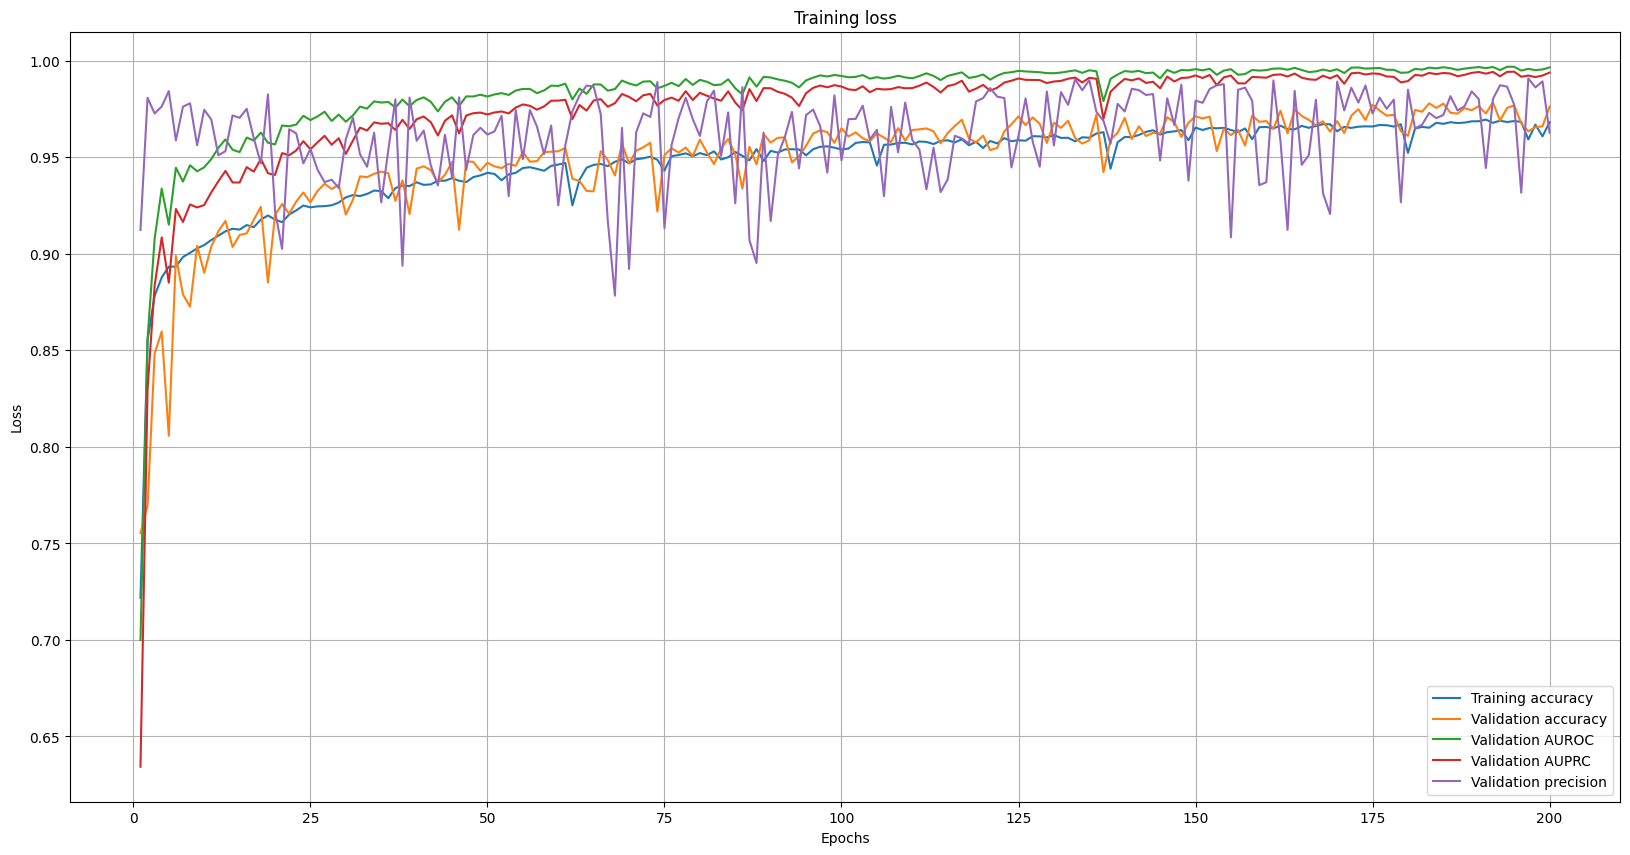

In [14]:
# Plot the training and validation loss and accuracy for each epoch for 4s partitions
with open('history_GAT_2.jason','r') as f:
    history_1 = pd.read_json(f)

training_accuracy = history_1['accuracy']
val_accuracy=history_1['val_accuracy']
training_loss = history_1['loss']
val_loss=history_1['val_loss']
val_AUROC=history_1['val_AUROC']
val_AUPRC=history_1['val_AUPRC']
val_precision=history_1['val_precision']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
plt.figure(figsize=(20, 10))
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
# plt.plot(epochs, training_loss, label='Training loss')
# plt.plot(epochs, val_loss, label='Validation loss')
plt.plot(epochs, val_AUROC, label='Validation AUROC')
plt.plot(epochs, val_AUPRC, label='Validation AUPRC')
plt.plot(epochs, val_precision, label='Validation precision')

# plt.axhline(y=0.3, color='r', linestyle='-')

# plt.axhline(y=0.975, color='r', linestyle='-')
plt.grid()
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.ylim([0, 1])    
plt.legend()
plt.show()

In [9]:
model=keras.models.load_model('./GAT_model/cp_0195.ckpt/')

In [11]:
model=keras.models.load_model('./GAT_model_1/cp_0198.ckpt/')

In [14]:
model.summary(show_trainable=True)

Model: "model_1"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_2 (InputLayer)        [(None, 12, 384, 1)]         0         []                            Y          
                                                                                                             
 conv2d_8 (Conv2D)           (None, 12, 384, 32)          128       ['input_2[0][0]']             Y          
                                                                                                             
 conv2d_9 (Conv2D)           (None, 12, 384, 32)          192       ['input_2[0][0]']             Y          
                                                                                                             
 add_4 (Add)                 (None, 12, 384, 32)          0         ['conv2d_8[0][0]',            Y    

In [12]:
model.evaluate(x1,y1,batch_size=512)

182/182 [==============================] - 9s 46ms/step - loss: 0.0717 - accuracy: 0.9361 - AUROC: 0.0000e+00 - AUPRC: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.07168826460838318, 0.9360951781272888, 0.0, 0.0, 0.0, 0.0]

In [13]:
model.evaluate(x_test,y_test,batch_size=512)

51/51 [==============================] - 2s 46ms/step - loss: 0.0151 - accuracy: 0.9625 - AUROC: 0.9908 - AUPRC: 0.9856 - precision: 0.9675 - recall: 0.9157


[0.015056755393743515,
 0.9625304341316223,
 0.9908108115196228,
 0.9856245517730713,
 0.9675072431564331,
 0.9156969785690308]